## bitcoin_prediction_LSMT

Simple model for bitcoin closing price prediction. They use a neural network to predict the prices, specifically, an LSTM network.
import pandas as pd

In [3]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
import datetime
import numpy as np

In [4]:
# get market info for bitcoin from the start of 2016 to the current day
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# when Volume is equal to '-' convert it to 0
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
# convert to int
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
# subset closing price and date
df = bitcoin_market_info[['Date','Close']]

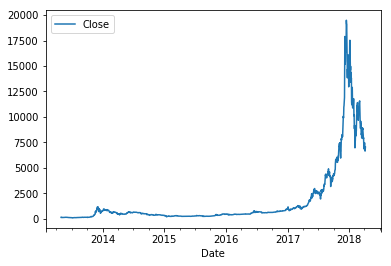

In [5]:
bitcoin_market_info.sort_values(by='Date').plot(x='Date', y='Close')

### Feature scaling
When using artificial neural networks we need to scale the values, otherwise the ANN function converge slowly.

In [5]:
lookback = 15
batch_size = 64
epochs = 50
test_size = 0.3

In [50]:
from sklearn.preprocessing import MinMaxScaler
values = df['Close'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [51]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

1263 542


In [15]:
def create_dataset(df, look_back=1):
    dataX, dataY = [], []
    for i in range(len(df) - look_back):
        a = df[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(df[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [17]:
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

1249
528


In [18]:
# reshape input into [samples, time_steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

#### LSTM (Long short-term memory model)  ... for time series

Recurrent neural networds (RNNs) should be capable to predict, based on recent information. However, they don't seem to be able to learn once the gap between the relevant context and the point where it is needed grows too large.

LSTMs do not have this problem, they are capable of learning long term dependencies.

#### Define Loss function 

A loss function measures how well a machine learning or statistics model fits empirical data of a certain phenomenon.

A loss function is an objective we wish to reduce. We want to create a model that can accurately predict what we want and to measure the performance of the model, one way is to look at the loss, since we know what the model outputs and what we should actually be getting. We can train and make our model better by using this loss and changing the features of our model accordingly.

In [19]:
# setting up the model 
from keras.preprocessing import sequence
from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model, Sequential
from keras.layers.core import Flatten

Using TensorFlow backend.


In [20]:
# running the LSMT model with 50 epochs
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(X_train, y_train, epochs=300, batch_size=100, validation_data=(X_test, y_test), verbose=0, shuffle=False)

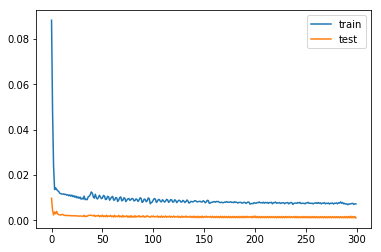

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### Make prediction and plot true vs. predicted

#### Re-inverse scaling
Before applying NNRs we need to scale the features [-1.1], no we apply the inverse function.

In linea di massima si indica con RMSE (Root Mean Squared Error) una misura di bontà di adattamento del modello, soprattutto in termini predittivi.

In [23]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

In [24]:
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 39.499


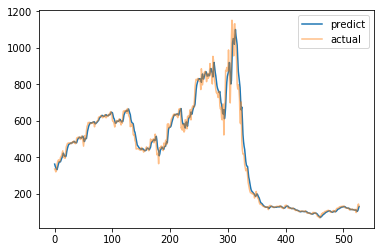

In [25]:
plt.plot(yhat_inverse, label='predict')
plt.plot(testY_inverse, label='actual', alpha=0.5)
plt.legend()
plt.show()

In [40]:
predictDates = df.tail(len(X_test)).index

In [27]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [42]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])